In [21]:
import random
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adamax
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
from keras import backend as K
import tensorflow as tf

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
import glob
from tqdm import tqdm
import scipy.misc
import imageio

In [22]:
print(TRAIN_PATH, TEST_PATH)

NameError: name 'TRAIN_PATH' is not defined

In [23]:
train_path='data-seg/train/'
val_path='data-seg/test/'

In [24]:
# Load train files
def load_data():
    # Loads the MNIST dataset from png images
 
    # create list of image objects
    test_images = []
    test_labels = []
 
    train_images = []
    train_labels = []
 
    trainfiles = glob.glob("data-seg/Train/*.png")
    trainfiles.sort()
    for image_path in trainfiles:
        image = imageio.imread(image_path)
        if "image_" in image_path:
            train_images.append(image)
        else:
            train_labels.append(image)
 
    testfiles = glob.glob("data-seg/Test/*.png")
    testfiles.sort()
    for image_path in testfiles:
        image = imageio.imread(image_path)
        if "image_" in image_path:
            test_images.append(image)
        else:
            test_labels.append(image)
 
    X_train = np.array(train_images) / 255.0
    Y_train = np.array(train_labels).reshape((-1, 128, 128, 1)) / 255.0
    X_test = np.array(test_images) / 255.0
    Y_test = np.array(test_labels).reshape((-1, 128, 128, 1)) / 255.0
 
    return X_train, Y_train, X_test, Y_test

In [25]:
x_train, y_train, x_test, y_test = load_data()
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.3, random_state=12345)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validate.shape, y_validate.shape,)

(59, 128, 128, 3) (59, 128, 128, 1) (60, 128, 128, 3) (60, 128, 128, 1) (26, 128, 128, 3) (26, 128, 128, 1)


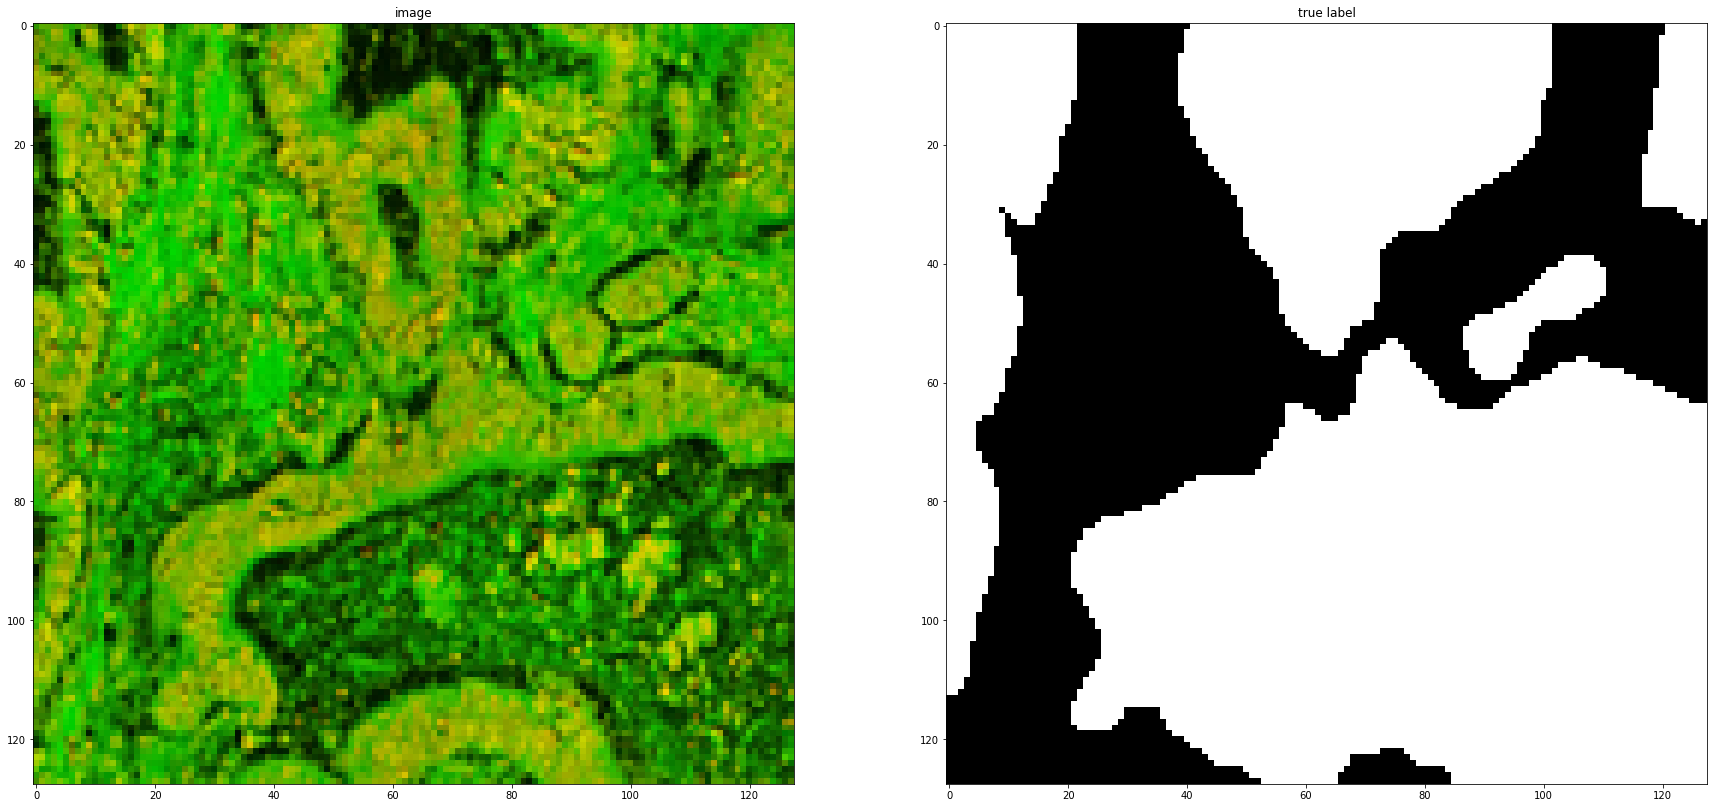

In [26]:
# Check if training data looks all right
r = random.randint(0, len(x_train))

fig, ax = plt.subplots(1, 2, figsize=(30, 30))

ax[0].imshow(x_train[r].squeeze(), cmap='twilight', interpolation='none')
ax[0].set_title('image')

ax[1].imshow(y_train[r].squeeze(), interpolation='none', cmap='gray')
ax[1].set_title('true label');

In [27]:
def conv_block(input_image, n_filters, kernel_size=3, batchnorm=True, dropoutprob=0.1):
    # first layer with batchnorm and dropout
    a = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_uniform",
               padding="same")(input_image)
    b = BatchNormalization()(a)
    d1 = Dropout(dropoutprob*0.5)(b)
    c = Activation("relu")(d1)
    # second layer with batchnorm and dropout
    d = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_uniform",
               padding="same")(c)
    e = BatchNormalization()(d)
    d2 =  Dropout(dropoutprob*0.25)(e)
    f = Activation("relu")(d2)
    return f

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [28]:
def get_unet(input_img, n_filters=16, batchnorm=True):
    # contracting path
    c1 = conv_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, dropoutprob=0.1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansion path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [29]:
input_img = Input((128, 128, 3), name='img')
model = get_unet(input_img, n_filters=16, batchnorm=True)

model.compile(optimizer=Adamax(), loss="categorical_hinge", metrics=['acc', f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 16) 64          conv2d_39[0][0]                  
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 128, 16) 0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
activation

In [30]:
callbacks = [
    EarlyStopping(patience=7, verbose=2),
    ReduceLROnPlateau(factor=0.6, patience=2, min_lr=0.0001, verbose=2, cooldown=1),
    ModelCheckpoint('model-ckpt1', verbose=2, save_best_only=True, save_weights_only=True)
]

In [31]:
results = model.fit(x_train, y_train, batch_size=17, epochs=20, callbacks=callbacks,
                    validation_data=(x_validate, y_validate), verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 59 samples, validate on 26 samples
Epoch 1/20
 - 19s - loss: 0.9479 - acc: 0.5425 - f1: 0.6548 - val_loss: 1.0019 - val_acc: 0.5690 - val_f1: 0.5505

Epoch 00001: val_loss improved from inf to 1.00187, saving model to model-ckpt1
Epoch 2/20
 - 14s - loss: 0.8943 - acc: 0.6227 - f1: 0.6962 - val_loss: 0.9250 - val_acc: 0.6672 - val_f1: 0.6384

Epoch 00002: val_loss improved from 1.00187 to 0.92503, saving model to model-ckpt1
Epoch 3/20
 - 16s - loss: 0.8447 - acc: 0.6973 - f1: 0.7404 - val_loss: 0.8835 - val_acc: 0.6850 - val_f1: 0.5634

Epoch 00003: val_loss improved from 0.92503 to 0.88350, saving model to model-ckpt1
Epoch 4/20
 - 17s - loss: 0.7994 - acc: 0.7563 - f1: 0.7846 - val_loss: 0.8429 - val_acc: 0.7128 - val_f1: 0.6369

Epoch 00004: val_loss improved from 0.88350 to 0.84292, saving model to model-ckpt1
Epoch 5/20
 - 20s - loss: 0.7743 - acc

KeyboardInterrupt: 

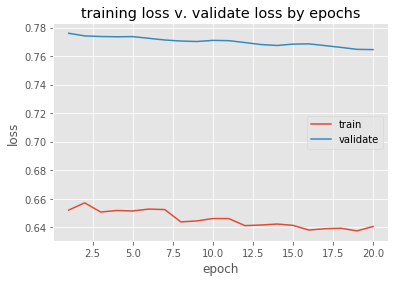

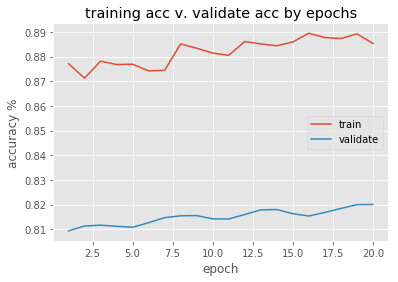

In [528]:
plt.plot(np.arange(1,21), np.asarray(results.history['loss']))
plt.plot(np.arange(1,21), np.asarray(results.history['val_loss']))

plt.title('training loss v. validate loss by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validate'], loc='right')
plt.show()

plt.plot(np.arange(1,21), np.asarray(results.history['acc']))
plt.plot(np.arange(1,21), np.asarray(results.history['val_acc']))

plt.title('training acc v. validate acc by epochs')
plt.ylabel('accuracy %')
plt.xlabel('epoch')

plt.legend(['train','validate'], loc='right')
plt.show()

In [529]:
model.load_weights("model-ckpt1")

In [530]:
model.evaluate(x_test, y_test, verbose=1)

60/60 [==============================] - 4s 70ms/step


[0.7826629638671875, 0.7592142780621847, 0.7710624217987061]

In [531]:
results = model.fit(x_train, y_train, batch_size=17, epochs=20, callbacks=callbacks,
                    validation_data=(x_test, y_test), verbose=2)

Train on 59 samples, validate on 60 samples
Epoch 1/20
 - 15s - loss: 0.6344 - acc: 0.8919 - f1: 0.8965 - val_loss: 0.7829 - val_acc: 0.7591 - val_f1: 0.7700

Epoch 00001: val_loss did not improve from 0.76456
Epoch 2/20
 - 15s - loss: 0.6383 - acc: 0.8878 - f1: 0.8926 - val_loss: 0.7847 - val_acc: 0.7572 - val_f1: 0.7653

Epoch 00002: val_loss did not improve from 0.76456
Epoch 3/20
 - 13s - loss: 0.6355 - acc: 0.8906 - f1: 0.8951 - val_loss: 0.7866 - val_acc: 0.7548 - val_f1: 0.7616

Epoch 00003: val_loss did not improve from 0.76456
Epoch 4/20
 - 13s - loss: 0.6351 - acc: 0.8908 - f1: 0.8960 - val_loss: 0.7881 - val_acc: 0.7523 - val_f1: 0.7595

Epoch 00004: val_loss did not improve from 0.76456
Epoch 5/20
 - 13s - loss: 0.6306 - acc: 0.8957 - f1: 0.9005 - val_loss: 0.7878 - val_acc: 0.7518 - val_f1: 0.7608

Epoch 00005: val_loss did not improve from 0.76456
Epoch 6/20
 - 15s - loss: 0.6313 - acc: 0.8945 - f1: 0.8996 - val_loss: 0.7869 - val_acc: 0.7531 - val_f1: 0.7616

Epoch 00006

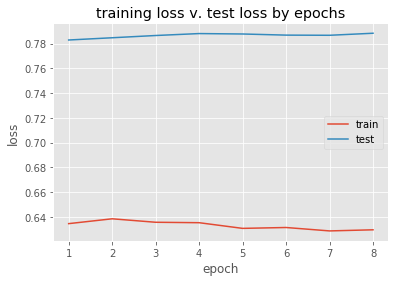

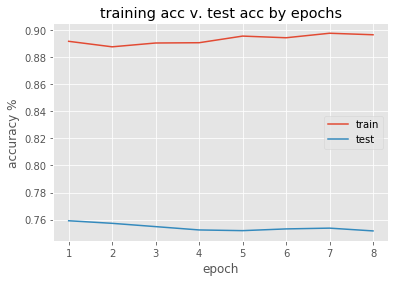

In [533]:
plt.plot(np.arange(1,9), np.asarray(results.history['loss']))
plt.plot(np.arange(1,9), np.asarray(results.history['val_loss']))

plt.title('training loss v. test loss by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='right')
plt.show()

plt.plot(np.arange(1,9), np.asarray(results.history['acc']))
plt.plot(np.arange(1,9), np.asarray(results.history['val_acc']))

plt.title('training acc v. test acc by epochs')
plt.ylabel('accuracy %')
plt.xlabel('epoch')

plt.legend(['train','test'], loc='right')
plt.show()

In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('label')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('image predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('label predicted');

In [ ]:
plot_sample(x_train, y_train, preds_train, preds_train_t, ix=14)

In [ ]:
plot_sample(x_test, y_test, preds_val, preds_val_t, ix=19)